In [6]:
from tqdm import tqdm   

import numpy as np
import pandas as pd
from datasets import load_dataset

import dl_translate as dlt

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, pipeline

import huggingface_hub
huggingface_hub.login() # now you will be prompted to enter your token; enter it.

In [7]:
!python -m spacy download en_core_web_lg
import spacy
import spacy_transformers
import torch

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/400.7 MB ? eta -:--:--
      -------------------------------------- 7.6/400.7 MB 47.1 MB/s eta 0:00:09
     - ------------------------------------ 17.3/400.7 MB 45.4 MB/s eta 0:00:09
     -- ----------------------------------- 30.4/400.7 MB 50.8 MB/s eta 0:00:08
     ---- --------------------------------- 44.3/400.7 MB 53.2 MB/s eta 0:00:07
     ----- -------------------------------- 56.1/400.7 MB 54.2 MB/s eta 0:00:07
     ------ ------------------------------- 69.5/400.7 MB 55.4 MB/s eta 0:00:06
     -------- ----------------------------- 85.5/400.7 MB 57.4 MB/s eta 0:00:06
     --------- ---------------------------- 99.6/400.7 MB 58.9 MB/s eta 0:00:06
     ---------- -------------------------- 113.2/400.7 MB 59.7 MB/s eta 0:00:05
     ----------- ------------------------- 126.6/400.7 MB 60.8 MB/s eta 0:00:05
     ------------- ----------------------- 141.3/


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Marcos Antenor\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# English processing use cases
This notebook aims to test the Task and Object identification in patents in english.

1. **Task:** the method used in the described patent. In can be compress something or agilize a effect, for example.
2. **Object:** the "target" of the task. It can be a food, a construction material or any other object that, combined with the task, defines the patent.

It is supposed that NLP techniques are more refined to english data as the models are well-developed and to validate this theory, all the patents will be translated to english to them be processed.

[DL-Translate](https://pypi.org/project/dl-translate/), a Python library that implements a low verbosity use of many open source models to translation tasks.

Three models can be used to translate from portuguese to english:
- [mBART-50 Large](https://huggingface.co/transformers/master/model_doc/mbart.html): Allows translations across 50 languages.
- [m2m100](https://huggingface.co/docs/transformers/model_doc/m2m_100): Allows translations across 100 languages.
- [nllb-200](https://huggingface.co/docs/transformers/model_doc/nllb): Allows translations across 200 languages, and is faster than m2m100 (On RTX A6000, we can see speed up of 3x).

# Model translation evaluation

To test the models we will evaluate using [FLORES+](https://huggingface.co/datasets/openlanguagedata/flores_plus) from Meta and evaluate the BLEU score for each model. This will serve as a benchmark to choose the best translating model to portuguese.

To do so, we have to download the portuguese and english bases and combine then by the ID.

In [8]:
ds_por = load_dataset("openlanguagedata/flores_plus", "por_Latn")
ds_por_df = ds_por['dev'].to_pandas()
ds_por_df.head()

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

,id,iso_639_3,iso_15924,glottocode,text,url,domain,topic,has_image,has_hyperlink,last_updated
0,0,por,Latn,braz1246,"Na segunda-feira, cientistas da Escola de Medi...",https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
1,1,por,Latn,braz1246,Os principais pesquisadores dizem que isso pod...,https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
2,2,por,Latn,braz1246,O JAS 39 Gripen se chocou com a pista por volt...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
3,3,por,Latn,braz1246,O piloto foi identificado como o Líder de Esqu...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
4,4,por,Latn,braz1246,A mídia local informa o capotamento de um veíc...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0


In [9]:
ds_en = load_dataset("openlanguagedata/flores_plus", "eng_Latn")
ds_en_df = ds_en['dev'].to_pandas()
ds_en_df.head()

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

,id,iso_639_3,iso_15924,glottocode,text,url,domain,topic,has_image,has_hyperlink,last_updated
0,0,eng,Latn,stan1293,"On Monday, scientists from the Stanford Univer...",https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
1,1,eng,Latn,stan1293,Lead researchers say this may bring early dete...,https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
2,2,eng,Latn,stan1293,The JAS 39C Gripen crashed onto a runway at ar...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
3,3,eng,Latn,stan1293,The pilot was identified as Squadron Leader Di...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
4,4,eng,Latn,stan1293,Local media reports an airport fire vehicle ro...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0


In [10]:
id = 0
print(f"English: {ds_en_df.loc[ds_en_df['id'] == id]['text'].values[0]}")
print(f"Portuguese: {ds_por_df.loc[ds_por_df['id'] == id]['text'].values[0]}")

English: On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
Portuguese: Na segunda-feira, cientistas da Escola de Medicina da Universidade de Stanford anunciaram a invenção de uma nova ferramenta de diagnóstico que pode classificar células por tipo: um minúsculo chip imprimível que pode ser fabricado usando impressoras jato de tinta padrão por possivelmente cerca de um centavo de dólar cada.


In [11]:
df_merged = ds_por_df[['id', 'text']].merge(
    ds_en_df[['id', 'text']],
    on='id',
    suffixes=('_pt', '_en')
)

df_merged.head()

,id,text_pt,text_en
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...


In [12]:
df_merged = df_merged.head(5)

In [13]:
print(f"Size of the evaluation dataset: {len(df_merged)}")

Size of the evaluation dataset: 5


First, we will process the data with m2m model

In [14]:
tqdm.pandas()

mt = dlt.TranslationModel(model_or_path="m2m100", device="cpu")


df_merged["m2m100_translation"] = df_merged["text_pt"].progress_apply(
    lambda x: mt.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
)

df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

df_merged.head()

100%|██████████| 5/5 [01:01<00:00, 12.34s/it]


,id,text_pt,text_en,m2m100_translation
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...


Now mbart-50

In [15]:
# Traduzindo os textos em português para inglês usando o modelo mbart50
mt_mbart50 = dlt.TranslationModel(model_or_path="mbart50", device="cpu")
df_merged["mbart50_translation"] = df_merged["text_pt"].progress_apply(
    lambda x: mt_mbart50.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
)

df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

100%|██████████| 5/5 [00:55<00:00, 11.06s/it]


Now unicamp-dl/translation-pt-en-t5

In [16]:
tokenizer = AutoTokenizer.from_pretrained("unicamp-dl/translation-pt-en-t5")
model = AutoModelForSeq2SeqLM.from_pretrained("unicamp-dl/translation-pt-en-t5")

pt_en_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

df_merged["unicamp_pt_en_t5"] = df_merged["text_pt"].progress_apply(
    lambda x: pt_en_pipeline(f"translate Portuguese to English: {x}")[0]['generated_text']
)

df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

Device set to use cpu
100%|██████████| 5/5 [00:57<00:00, 11.57s/it]


Now facebook/nllb-200-distilled-600M

In [17]:
tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/nllb-200-distilled-600M")

translator = pipeline("translation", model=model, tokenizer=tokenizer, src_lang="por_Latn", tgt_lang="eng_Latn")

df_merged["facebook_nlb_200"] = df_merged["text_pt"].progress_apply(
    lambda x: translator(x)[0]["translation_text"]
)

df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

Device set to use cpu
100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


Now Helsinki-NLP/opus-mt-mul-en

In [18]:
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-mul-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-mul-en")

translator = pipeline("translation", model=model, tokenizer=tokenizer)

df_merged["helsink_opus_mult"] = df_merged["text_pt"].progress_apply(
    lambda x: translator(x)[0]["translation_text"]
)

df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

C:\Users\Marcos Antenor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu
100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


Now google/madlad400-3b-mt

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("google/madlad400-3b-mt")
model = AutoModelForSeq2SeqLM.from_pretrained("google/madlad400-3b-mt")

translator = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

df_merged["google_madlad_3b"] = df_merged["text_pt"].progress_apply(
    lambda x: translator(f">>en<< {x}")[0]["generated_text"]
)

df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

spiece.model:   0%|          | 0.00/4.43M [00:00<?, ?B/s]

Now ByteDance

In [ ]:
model_name = "ByteDance/Seed-X-PPO-7B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)

translator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
)

def translate_bytedance(text_pt):
    prompt = f"Translate the following Portuguese sentence into English:\n{text_pt} <en>"
    output = translator(prompt, max_new_tokens=128, do_sample=False, temperature=0.0)[0]["generated_text"]
    translation = output.replace(prompt, "").strip()
    return translation

df_merged["bytedance_seedx"] = df_merged["text_pt"].progress_apply(translate_bytedance)

df_merged.to_csv("../../data/processed/translation_benchmark_seedx_pt_en.csv", index=False)

In [ ]:
df_merged.head()

,id,text_pt,text_en,m2m100_translation,mbart50_translation,unicamp_pt_en_t5,nllb_translation,opus_mt_mul_en_translation
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S...","On Monday, scientists at Stanford Medical Scho...","On Monday, scientists from the Stanford Univer...","On Monday, scientists at Stanford University S...","On Tuesday, scientists at Stanford University ..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...,Leading researchers say this can lead to early...,The main researchers say that this may lead to e,Leading researchers say this could lead to ear...,The main researchers say that this can lead to...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...,JAS 39 Gripen slammed into the runway at about...,The JAS 39 Gripen stinged around 9:30 at the l...,JAS 39 Gripen crashed into the runway around 9...,The JAS 39 Gripen hit the track around 9:30 at...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...,The pilot was identified as Commander-in-Chief...,The pilot was identified as the Squad Leader D...,The pilot has been identified as Squadron Lead...,The pilot was identified as the Dilokrit Patta...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...,The local media reports a helicopter capsize f...,The local media reports the capture of a fire ...,Local media reports a fire truck from the airp...,The local media will report the capture of an ...


Calculo Bleu

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calc_bleu(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)

df_merged["bleu_m2m100"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["m2m100_translation"]), axis=1
)

df_merged["bleu_mbart50"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["mbart50_translation"]), axis=1
)

df_merged["bleu_unicamp"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["unicamp_pt_en_t5"]), axis=1
)

df_merged["bleu_facebook"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["facebook_nlb_200"]), axis=1
)

df_merged["bleu_helsink"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["helsink_opus_mult"]), axis=1
)

df_merged[["text_en", "m2m100_translation", "mbart50_translation", 
           "unicamp_pt_en_t5", "facebook_nlb_200", "helsink_opus_mult" 
           "bleu_m2m100", "bleu_mbart50", "bleu_unicamp,"
           "bleu_facebook", "bleu_helsink"]].head()

,text_en,m2m100_translation,mbart50_translation,bleu_m2m100,bleu_mbart50
0,"On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S...","On Monday, scientists at Stanford Medical Scho...",0.608199,0.462046
1,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...,Leading researchers say this can lead to early...,0.285757,0.222648
2,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...,JAS 39 Gripen slammed into the runway at about...,0.413621,0.059216
3,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...,The pilot was identified as Commander-in-Chief...,0.525382,0.524736
4,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...,The local media reports a helicopter capsize f...,0.045999,0.052841


In [ ]:
df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

Matplotlib is building the font cache; this may take a moment.


([<matplotlib.axis.XTick at 0x1ed20bca9f0>,
 [Text(0, 0, 'm2m100'), Text(1, 0, 'mbart50')])

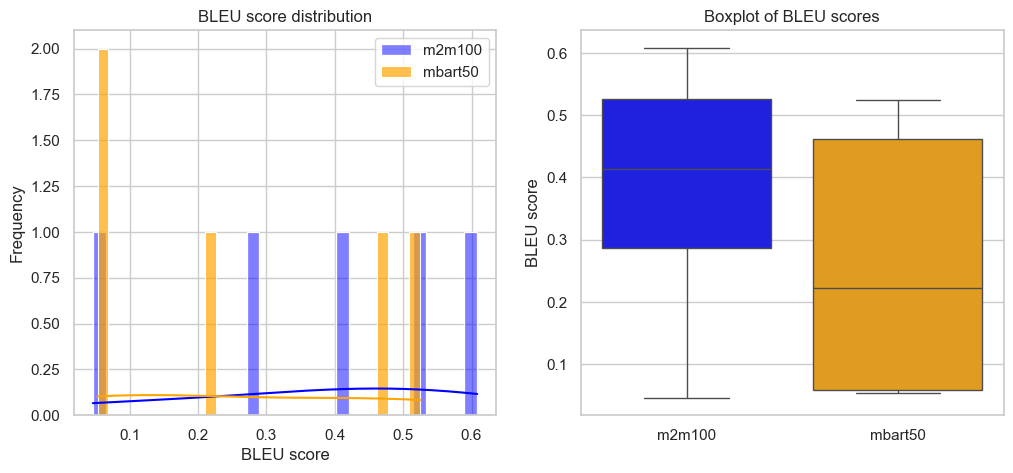

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df_merged["bleu_m2m100"], bins=30, color="blue", kde=True, label="m2m100", alpha=0.7)
sns.histplot(df_merged["bleu_mbart50"], bins=30, color="orange", kde=True, label="mbart50", alpha=0.7)
sns.histplot(df_merged["bleu_unicamp"], bins=30, color="red", kde=True, label="unicamp", alpha=0.7)
sns.histplot(df_merged["bleu_facebook"], bins=30, color="purple", kde=True, label="facebook", alpha=0.7)
sns.histplot(df_merged["bleu_helsink"], bins=30, color="green", kde=True, label="helsink", alpha=0.7)
plt.title("BLEU Score Distribution")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.legend()

# Boxplot comparativo
plt.subplot(1, 2, 2)
sns.boxplot(
    data=df_merged[[
        "bleu_m2m100", "bleu_mbart50", "bleu_unicamp", "bleu_facebook", "bleu_helsink"
    ]],
    palette=["blue", "orange", "red", "purple", "green"]
)
plt.title("Boxplot of BLEU Scores")
plt.ylabel("BLEU Score")
plt.xlabel("Model")

plt.tight_layout()
plt.show()

As seen, m2m have a better overwll performance whem compared to mbart50. For now, we will use this model to translate the patents

# Best model application to translate

In [ ]:
df_patents = pd.read_csv("../../data/raw/patentes_inpi.csv")
df_patents.head()

In [ ]:
mt = dlt.TranslationModel(model_or_path="m2m100", device="gpu")


df_patents["titulo_english"] = df_patents["titulo"].progress_apply(
    lambda x: mt.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH, batch_size=64)
)
df_patents.head()

In [ ]:
df_patents.to_csv("../../data/processed/patents_inpi_translated.csv", index=False)

In [ ]:
# df_patents["resumo_english"] = df_patents["resumo"].progress_apply(
#     lambda x: mt.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH, batch_size=32)
# )
# df_patents.head()

# df_patents.to_csv("../../data/processed/patents_inpi_translated.csv", index=False)

In [ ]:
df_patents.head()

As the summaries are substantially longer texts, the processing time are much longer. For now, we will not use these texts

# Loading english TRIZ database and preparing the matcher

In [ ]:
triz_multilanguage = pd.read_excel("../../data/raw/Base efeitos físicos MULTILINGUE funçãoxlsx.xlsx")

en_columns = ["Mode", "Type", "Task", "Target", "Name", "Description", "EN Link"]
triz_multilanguage[en_columns].head()

We will use the pipeline of Transformers in spaCy for the english

In [ ]:
# ref.: https://spacy.io/models/en
# nlp = spacy.load('en_core_web_trf')
nlp = spacy.load('en_core_web_lg')


In [ ]:
def find_matches(input_string, list_of_vectors, threshold=None, top_n=None):
    """
    Vectorizes every word in the input string and compares its vectors to a list of precomputed vectors.
    Returns matches based on a similarity threshold or the top_n most similar terms.

    Args:
        input_string (str): The input string to be vectorized.
        list_of_vectors (list): Precomputed vectors of the list of strings.
        threshold (float, optional): Similarity threshold for matches. Default is None.
        top_n (int, optional): Number of top matches to return based on similarity. Default is None.

    Returns:
        list: Indices of matches in the list_of_vectors.
    """
    if threshold is None and top_n is None:
        raise ValueError("You must provide either a threshold or top_n.")

    words = input_string.split()
    all_similarities = []

    for word in words:
        # ref.: https://stackoverflow.com/questions/68959472/no-vector-when-using-spacy-loaden-core-web-trf
        # input_vector = nlp(word)._.trf_data.last_hidden_layer_state.data[0]
        input_vector = nlp(word).vector

        # Calculate similarity for each vector
        for i, vector in enumerate(list_of_vectors):
            similarity = np.dot(input_vector, vector) / (np.linalg.norm(input_vector) * np.linalg.norm(vector))
            all_similarities.append((i, similarity))

    # Filter by threshold if provided
    matches = []
    if threshold is not None:
        matches.extend([i for i, sim in all_similarities if sim >= threshold])

    # Get top_n matches across all words if provided
    if top_n is not None:
        top_matches = sorted(all_similarities, key=lambda x: x[1], reverse=True)[:top_n]
        matches.extend([i for i, _ in top_matches])

    # Remove duplicates and return
    return list(matches)

In [ ]:
# Path to the saved vectors
tarefas_vectors_path = "../../data/processed/tarefas_vectors_english.npz"

try:
    # Try to load the precomputed vectors
    tarefas_vectors = np.load(tarefas_vectors_path)["vectors"]
    print("Loaded precomputed vectors successfully.")
except (FileNotFoundError, KeyError):
    # If loading fails, recalculate the vectors
    print("Precomputed vectors not found. Recalculating...")
    tarefas = triz_multilanguage["Task"].astype(str).unique().tolist()

    # ref.: https://stackoverflow.com/questions/68959472/no-vector-when-using-spacy-loaden-core-web-trf
    # tarefas_vectors = np.array([nlp(tarefa)._.trf_data.last_hidden_layer_state.data[0] for tarefa in tarefas])
    tarefas_vectors = np.array([nlp(tarefa).vector for tarefa in tarefas])
    
    # Save the recalculated vectors
    np.savez(tarefas_vectors_path, vectors=tarefas_vectors)
    print("Vectors recalculated and saved.")

In [ ]:
# Apply the function to df.loc[25, "titulo_lemmatized"]
k = 10
matches = find_matches(df_patents.loc[k, "titulo_english"], tarefas_vectors, threshold=0.4 )

# Print the matched indices and corresponding strings
print("\n\n")
print(df_patents.loc[k, "titulo_english"])
print("Matched indices:", matches)
print("Matched strings:", set([tarefas[i] for i in matches]))

In [ ]:
from tqdm import tqdm

result = []
for index, row in tqdm(df_patents.iterrows(), total=df_patents.shape[0]):
    res = find_matches(str(row["titulo_english"]), tarefas_vectors, top_n=10)
    result.append(res)

In [ ]:
# Ensure each row in the DataFrame gets its corresponding set of matches
df_patents["match_top_10_title"] = [set([tarefas[i] for i in res]) for res in result]

# Save the updated DataFrame to a CSV file
df_patents.to_csv("../../data/processed/patentes_inpi_english_matched.csv", index=False)